In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline
from IPython.core.display import HTML
import statsmodels.api as sm
import statsmodels.formula.api as smf
import dash_core_components as dcc
import dash_html_components as htmlfr
import plotly.express as px
import pandas as pd
import numpy as np
import os
import chart_studio
import itertools
from collections import Counter
import plotly.graph_objects as go
import networkx as nx
import streamlit as st
import ipywidgets as w
from IPython.display import display

In [13]:
path_to_download_folder = str(os.path.join(Path.home(), "Downloads"))

In [15]:
admit = pd.read_csv(os.path.join(path_to_download_folder, "Admit.csv"))
patients = pd.read_csv(os.path.join(path_to_download_folder, "Patient.csv"))
diagnosis = pd.read_csv(os.path.join(path_to_download_folder, "Diagnosis (2).csv"))
# add time stayed in the hospital
diagnosis['staylength']= pd.to_datetime(diagnosis['dischtime']) - pd.to_datetime(diagnosis['admittime'])
diagnosis['staylength'] = pd.to_timedelta(diagnosis.staylength).dt.total_seconds()
# Convert seconds to days
diagnosis['staylength'] = diagnosis['staylength']/(24*60*60)

# regroup ethnicity
diagnosis.loc[diagnosis.ethnicity.str.contains('^ASIAN'), 'ethnicity'] = 'ASIAN'
diagnosis.loc[diagnosis.ethnicity.str.contains('^HISPANIC/LATINO'), 'ethnicity'] = 'HISPANIC OR LATINO'
diagnosis.loc[diagnosis.ethnicity.str.contains('^BLACK'), 'ethnicity'] = 'BLACK'
diagnosis.loc[diagnosis.ethnicity.str.contains('^WHITE'), 'ethnicity'] = 'WHITE'
diagnosis.loc[diagnosis.ethnicity == 'UNABLE TO OBTAIN', 'ethnicity'] = 'UNKNOWN/NOT SPECIFIED'
main_cats = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'UNKNOWN/NOT SPECIFIED', 
             'HISPANIC OR LATINO', 'ASIAN', 'OTHER']
diagnosis.loc[~diagnosis.ethnicity.isin(main_cats), 'ethnicity'] = 'OTHER'

In [17]:
def filter_data(diagnosis, disease):
    """
    Creates a datarame of people who have a given disease as one of their diagnoses.
    Inputs:
    """
    filtered_data = diagnosis.loc[diagnosis['subject_id'][diagnosis['short_title'] == disease]]
    return(filtered_data)
    

In [19]:
def topn_diagnoses(diagnosis, n):
    """
    Creates a list of lists containing the top n most frequent diagnoses.
    Inputs:
        diagnosis_matrix: A column containing diagnosis data for patients.
        n: Number of diseases to examine.
    Outputs:
        corpus: A list of lists containing all the diagnoses. One list for each patient.
    """
    diagnosis_subset= diagnosis[['subject_id', 'short_title', 'seq_num']]
    top_n= diagnosis_subset['short_title'].value_counts()[:n].index.tolist()
    subset_matrix= diagnosis_subset[diagnosis_subset['short_title'].isin(top_n)]
    subset_matrix = subset_matrix.groupby('subject_id')['short_title'].apply(','.join).reset_index()
    diagnoses = subset_matrix['short_title'].to_list()
    corpus = []
    for i in diagnoses:
        corpus.append(i.split(','))
    return (corpus)

In [20]:
import numpy as np
import nltk
from nltk import bigrams
import itertools
import pandas as pd
 
def gen_matrix(corpus):
    """
    Creates a co-occurrence matrix from a corpus/list.
    
    Inputs:
        Corpus: A List of list of words.
    Outputs:
        matrix: A co-occurrence matrix. 
        vocab_index: A list of all the words in the vocabulary.
    """
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        matrix[pos_current][pos_previous] = count
    matrix = np.matrix(matrix)
 
    # return the matrix and the index
    return matrix, vocab_index
 

In [21]:
def matrix_to_df(diagnosis_data, n):
    """
    Creates a co-occurence matrix and converts it to a pandas dataframe.
    Inputs:
        diagnosis_data: A co-occurrence matrix.
        n: The number of diseases you want ot analyze.
    Outputs:
        pandas_matrix: a dataframe of the co-occurrence matrix.
    """
    # Generate corpus
    corpus = topn_diagnoses(diagnosis_data, n)
    # Create one list using many lists
    data = list(itertools.chain.from_iterable(corpus))
    # Create co-occurrence matrix
    matrix, vocab_index = gen_matrix(data)
    # Put Matrix into pandas df
    pandas_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)
    return(pandas_matrix)

In [22]:
data_matrix = matrix_to_df(filter_data(diagnosis, 'Hyperpotassemia'), 25)

In [23]:
# Create graph object and prepare for graphing
g = nx.from_numpy_matrix(data_matrix.to_numpy())
pos= nx.fruchterman_reingold_layout(g)
N = list(data_matrix.columns)
Node = g.nodes()
E = g.edges()
labels= N
for n, p in pos.items():
    g.nodes[n]['pos'] = p
# Get sizes of nodes
sizes = data_matrix.sum(axis=0).to_list()
sizeref = 2. * max(sizes) / (10** 2)

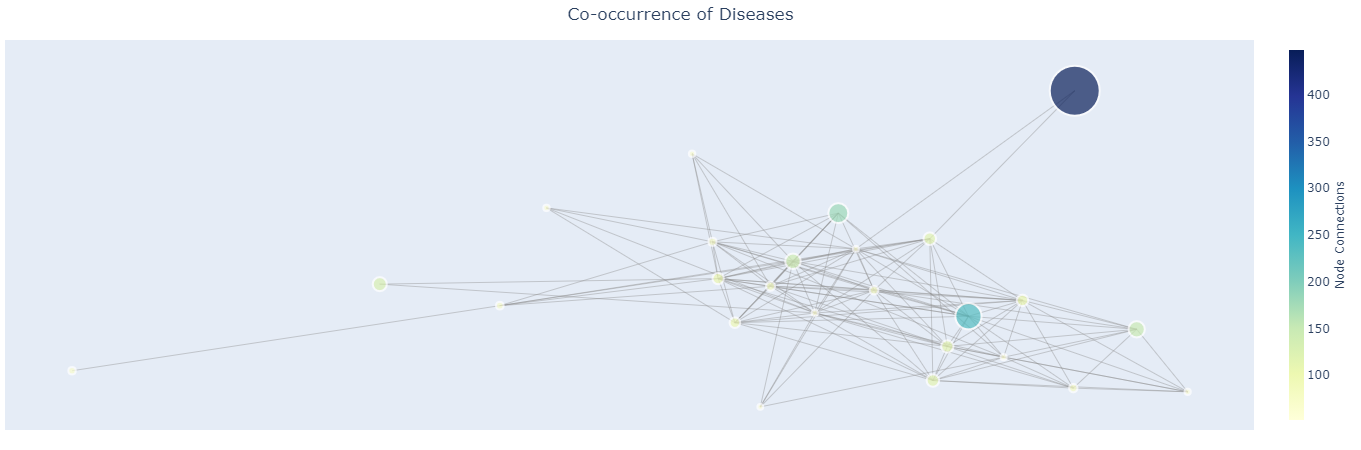

In [24]:
edge_x = []
edge_y = []
for edge in g.edges():
    x0, y0 = g.nodes[edge[0]]['pos']
    x1, y1 = g.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

node_adjacencies = []
node_text = []
i=0
for node, adjacencies in enumerate(g.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('Disease:' +str(labels[i]) +', Number of Connections: '+str(int(sizes[i])))
    i+=1
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width= .4, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in g.nodes():
    x, y = g.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'greys' | 'YlgnBu' | 'greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlgnBu',
        reversescale=False,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))


node_trace.marker.color = sizes
node_trace.marker.size = [s for  s in sizes]
node_trace.marker.sizeref = sizeref
node_trace.text = node_text

data=[edge_trace, node_trace]
layout = go.Layout(
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
fig = go.Figure(data=data,
             layout= layout)
fig.update_layout(title = 'Co-occurrence of Diseases', title_x = .50)

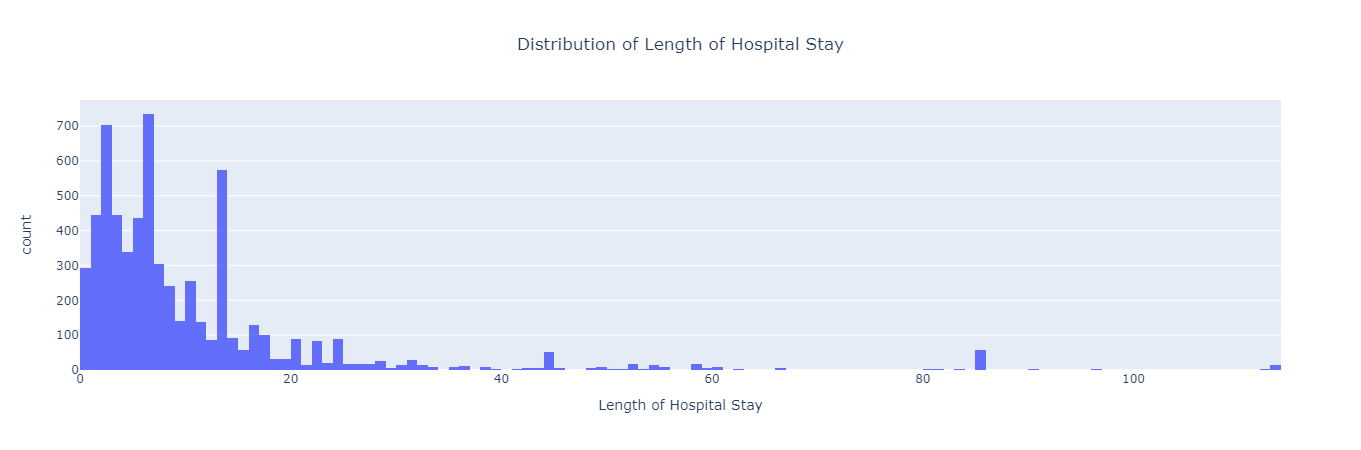

In [25]:
# Look at hospital stay length
df = filter_data(diagnosis, 'Hyperpotassemia')
fig = px.histogram(df, x="staylength", title = 'Distribution of Length of Hospital Stay', labels = {"staylength":"Length of Hospital Stay"})
fig.update_layout(title_x = .50)

fig.show()

In [26]:
# calculate relative disease frequency by race
def disease_freq(diagnosis, disease):
    ethnic_total = diagnosis.groupby('ethnicity').count()[['row_id']]
    subset_total = filter_data(diagnosis, disease).groupby('ethnicity').count()[['row_id']]
    scaled_data = (subset_total/ethnic_total)
    scaled_data['row_id'][pd.isna(scaled_data["row_id"])] = 0
    scaled_data = scaled_data.reset_index()
    scaled_data = scaled_data.sort_values(by='row_id', ascending=False)
    scaled_data['row_id'] = scaled_data['row_id'] * 100
    return(scaled_data)


def admit_freq(diagnosis):
    """
    Calculate admission location proportions. 
    """
    admit_total = diagnosis.groupby('admission_location').count()[['row_id']]
    admit_total = admit_total.reset_index()
    admit_total = admit_total.sort_values(by='row_id', ascending=False)
    return(admit_total)

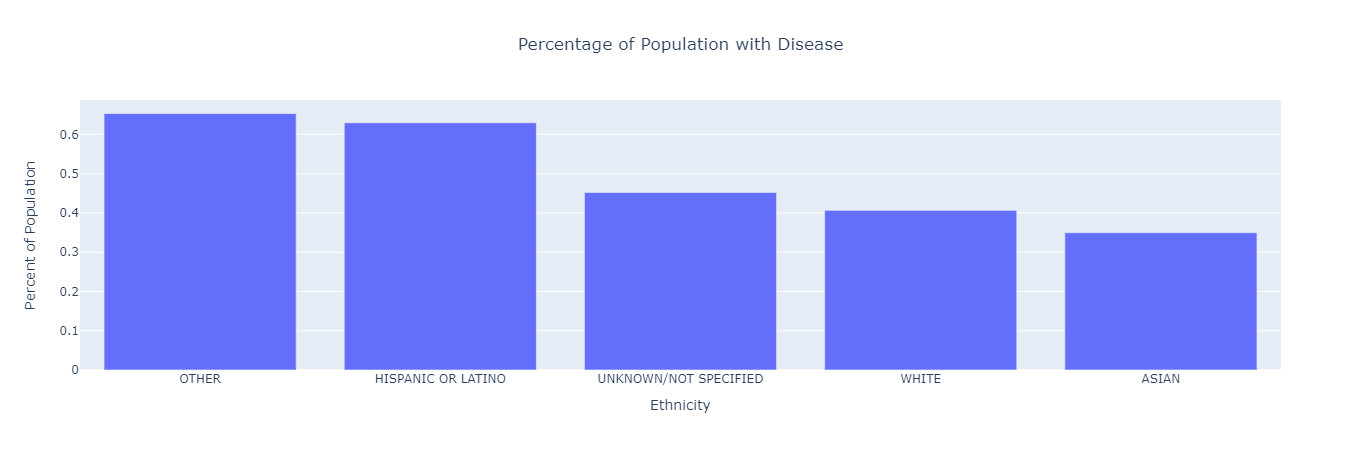

In [27]:
# Plot relative disease frequency 
fig = px.bar(disease_freq(diagnosis,'Hyperpotassemia'), x='ethnicity', y='row_id', title = 'Percentage of Population with Disease', labels = {'ethnicity': 'Ethnicity', 'row_id':'Percent of Population'})
fig.update_layout(title_x=.50)
fig.show()

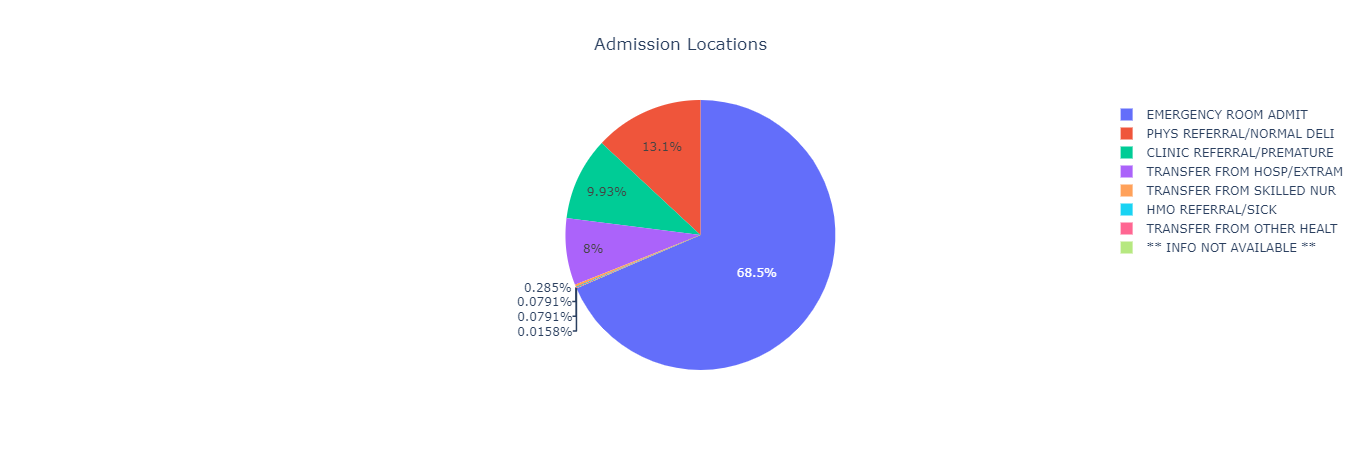

In [28]:
# Plot admission location frequency 
fig = px.pie(admit_freq(filter_data(diagnosis,'Hyperpotassemia')), names='admission_location', values='row_id', title = 'Admission Locations')
fig.update_layout(title_x=.50)
fig.show()